In [1]:
import fastai
from fastai import *
from fastai.text import * 
from fastai.text.models import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import swifter
import nltk
from nltk.corpus import stopwords
import re 
from bs4 import BeautifulSoup
from sklearn.metrics import precision_score, recall_score
from nltk.stem.snowball import SnowballStemmer

In [2]:
DATA_PATH = Path('Input_data')
MODEL_LM_PATH = Path('models_lm')
MODEL_LM_PATH.mkdir(exist_ok=True)
MODEL_TEXT_TAB_PATH = Path('models_text_tab')
MODEL_TEXT_TAB_PATH.mkdir(exist_ok=True)

In [3]:
class ConcatDataset(Dataset):
    def __init__(self, x1, x2, y):
        self.x1, self.x2, self.y = x1, x2, y
    def __len__(self): 
        return len(self.y)
    def __getitem__(self, i): 
        return (self.x1[i], self.x2[i]), self.y[i]
    
# define a custom collate function to be used to create a Concat DataBunch later
def tabtext_collate(batch):
    x, y = list(zip(*batch))
    # x1 is (cat,cont), x2 is numericalized ids for text
    x1, x2 = list(zip(*x))
    x1 = to_data(x1)
    x1 = list(zip(*x1))
    x1 = torch.stack(x1[0]), torch.stack(x1[1])
    x2, y = pad_collate(list(zip(x2, y)), pad_idx=1, pad_first=True)
    return (x1, x2), y

In [4]:
class ConcatModel(nn.Module):
    def __init__(self, mod_tab, mod_nlp, layers, drops):
        super().__init__()
        self.mod_tab = mod_tab
        self.mod_nlp = mod_nlp
        lst_layers = []
        activs = [nn.ReLU(inplace=True), ] * (len(layers)-2) + [None]
        for n_in, n_out, p, actn in zip(layers[:-1], layers[1:], drops, activs):
            lst_layers += bn_drop_lin(n_in, n_out, p=p, actn=actn)
        self.layers = nn.Sequential(*lst_layers)

    def forward(self, *x):
        x_tab = self.mod_tab(*x[0])
        x_nlp = self.mod_nlp(x[1])[0]
        x = torch.cat([x_tab, x_nlp], dim=1)
        return self.layers(x)

In [5]:
fulldata= pd.read_csv('Input_data/newdata.csv')

,Unnamed: 0,Integration Type,Language,Sentiment,Text,experience,service,consistency,value,food,convenience,lang_code,raw_text,Unnamed: 0.1,Categories,pred
0,0,eetnu,nld,-1,Food was tasty but far too little compared to ...,1.0,0.0,0.0,0.0,0.0,0.0,nl,Eten was lekker maar veel te weinig vergeleken...,NaN,NaN,NaN
1,1,resengo,nld,-1,Super,0.0,1.0,0.0,0.0,0.0,0.0,nl,Super,NaN,NaN,NaN
2,4,zomato,por,-1,"Maybe the expectations are so high, we were so...",1.0,0.0,0.0,0.0,0.0,0.0,pt,"Talvez pelas expectativas serem tão altas, que...",NaN,NaN,NaN
3,5,zomato,por,1,Burger is always good. I confess having had a ...,1.0,1.0,1.0,1.0,1.0,0.0,pt,Hambúrguer é sempre bom. Confesso já ter tido ...,NaN,NaN,NaN
4,6,zomato,por,1,I'm a fan of the hamburger in the neighborhood...,1.0,1.0,1.0,1.0,0.0,1.0,pt,Sou fã da hamburgueria do bairro! Sempre achei...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10452,4925,formitable,eng,-1,- standing in a row at the entrance and host w...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10332.0,food;service,-1.0
10453,4926,google_mybusiness,eng,-1,Very poor service & the food was really bad. D...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10394.0,service;food;value;experience,-1.0
10454,4927,facebook,eng,-1,"Very rude, unfriendly personal which reacts qu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10448.0,service,-1.0
10455,4928,google_mybusiness,eng,-1,"Bad service, horrible taste and the food nothi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10452.0,experience;food;service,-1.0


In [9]:
fulldata.drop(columns=['raw_text', 'pred', 'Unnamed: 0.1', 'Categories', 'Unnamed: 0'], inplace=True)

In [10]:
df_train = fulldata[:8000]
df_valid = fulldata[8000:]

In [12]:
val_idxs = np.arange(df_train.shape[0], fulldata.shape[0])

In [13]:
bs = 32

# create Databunch (https://docs.fast.ai/text.data.html)
data_lm = (TextList.from_df(fulldata, cols=['Text'])
                           .split_by_idx(val_idxs)
                           .label_for_lm()  
                           .databunch(path=MODEL_LM_PATH, bs=bs))

In [14]:
data_lm.save('data_lm.pkl')

In [15]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, path=MODEL_LM_PATH)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 3.02E-02


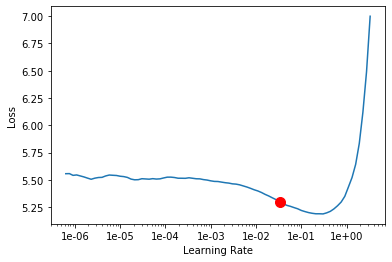

In [16]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_lr = learn.recorder.min_grad_lr

In [ ]:
learn.fit_one_cycle(1, min_lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_lr = learn.recorder.min_grad_lr

In [0]:
learn.fit_one_cycle(5, min_lr, moms=(0.8,0.7)) 


In [0]:
learn.save_encoder('fine_tuned_enc')